## Make a function that runs prompt on an image and return text. Use ‘ollama’
Python library; don’t forget to install it and have Ollama app running too

In [37]:
import sys
print(sys.executable)
print(sys.path)

/usr/bin/python3.12
['/usr/lib64/python312.zip', '/usr/lib64/python3.12', '/usr/lib64/python3.12/lib-dynload', '', '/usr/local/lib64/python3.12/site-packages', '/usr/local/lib64/python3.12/site-packages/flash_attn-2.8.0.post2-py3.12-linux-x86_64.egg', '/usr/local/lib/python3.12/site-packages', '/usr/lib64/python3.12/site-packages', '/usr/lib/python3.12/site-packages', '/users/hahmadin/.local/lib/python3.12/site-packages']


In [38]:
!python3.12 -m pip install --user -U ollama

In [39]:
import site, sys

user_site = site.getusersitepackages()
print("User site:", user_site)

if user_site not in sys.path:
    sys.path.append(user_site)

print("Now sys.path contains user site:", user_site in sys.path)

User site: /users/hahmadin/.local/lib/python3.12/site-packages
Now sys.path contains user site: True


In [40]:
import ollama
ollama.list()

ListResponse(models=[Model(model='embeddinggemma:latest', modified_at=datetime.datetime(2026, 1, 4, 17, 16, 35, tzinfo=TzInfo(+02:00)), digest='85462619ee721b466c5927d109d4cb765861907d5417b9109caebc4e614679f1', size=621875917, details=ModelDetails(parent_model='', format='gguf', family='gemma3', families=['gemma3'], parameter_size='307.58M', quantization_level='BF16')), Model(model='ministral-3:3b', modified_at=datetime.datetime(2026, 1, 4, 17, 16, 15, tzinfo=TzInfo(+02:00)), digest='f04aa1c738f64e13c625b82ae92504fc0260fa6723b509ed1ece0fa188179b1d', size=2953840808, details=ModelDetails(parent_model='', format='gguf', family='mistral3', families=['mistral3'], parameter_size='3.8B', quantization_level='Q4_K_M'))])

In [41]:
def prompt_image(image_path: str, model: str = "ministral-3:3b") -> str:
    prompt = "Describe briefly what happens in this image, in English."
    r = ollama.generate(model=model, prompt=prompt, images=[image_path])
    return r["response"].strip()

In [42]:
print(prompt_image("bear.jpg"))

This image depicts a grizzly bear standing on a rocky outcrop. The bear appears to be in a natural, forested environment, possibly during autumn given the foliage colors. It looks alert and is positioned with its body facing slightly to the left, observing its surroundings.


## Make another function that computes embedding of a string using
“embeddinggemma” model, and returns a Numpy array

In [43]:
import numpy as np

In [44]:
def compute_embedding(text: str, model: str = "embeddinggemma") -> np.ndarray:
    """
    Compute embedding of a string using embeddinggemma and return a NumPy array.
    """
    resp = ollama.embeddings(model=model, prompt=text)
    return np.array(resp["embedding"], dtype=np.float32)

In [45]:
vec = compute_embedding("A bear standing in a forest.")
print(type(vec))
print(vec.shape)
print(vec[:10])

<class 'numpy.ndarray'>
(768,)
[-0.1208263  -0.03439324  0.04332991 -0.00056506 -0.01194784  0.02637038
 -0.03892335  0.04820772  0.02226989  0.00087709]


In [46]:
caption = prompt_image("bear.jpg")
vec2 = compute_embedding(caption)

print("Caption:", caption)
print("Embedding shape:", vec2.shape)

Caption: This image depicts a grizzly bear standing on a rocky outcrop or ledge. The bear appears to be in a natural, forested environment, possibly during autumn given the foliage colors. It looks alert and is positioned with its body oriented slightly to the side, observing its surroundings.
Embedding shape: (768,)


## Make our “model”: a Pandas dataframe with columns “filename”, “description”,
“embedding” (a Numpy array)

In [47]:
import pandas as pd

In [48]:
def build_image_model(filenames):
    """
    Builds a Pandas DataFrame with columns:
    filename | description | embedding
    """
    rows = []

    for fname in filenames:
        desc = prompt_image(fname)
        emb = compute_embedding(desc)

        rows.append({
            "filename": fname,
            "description": desc,
            "embedding": emb
        })

    return pd.DataFrame(rows)

In [49]:
image_files = ["bear.jpg"]   # add more images later if needed

df_model = build_image_model(image_files)
df_model

,filename,description,embedding
0,bear.jpg,This image depicts a grizzly bear standing on ...,"[-0.07386555, -0.023291236, -0.012166852, 0.03..."


In [50]:
type(df_model.loc[0, "embedding"]), df_model.loc[0, "embedding"].shape

(numpy.ndarray, (768,))

## Make a function that take Pandas dataframe “model”, a new Embedding
vector, and returns filename+description for the most similar “model” vector

In [51]:
import numpy as np

def most_similar(model, query_embedding: np.ndarray):
    """
    model: pandas DataFrame with columns [filename, description, embedding]
    query_embedding: numpy array
    Returns: (filename, description, similarity_score)
    """
    # Stack embeddings from the DataFrame into a 2D array (n_items, dim)
    emb_matrix = np.stack(model["embedding"].values)

    # Cosine similarity: (A·b) / (||A|| * ||b||)
    q = query_embedding.astype(np.float32)
    q_norm = np.linalg.norm(q) + 1e-12

    emb_norms = np.linalg.norm(emb_matrix, axis=1) + 1e-12
    sims = (emb_matrix @ q) / (emb_norms * q_norm)

    best_idx = int(np.argmax(sims))
    best_row = model.iloc[best_idx]

    return best_row["filename"], best_row["description"], float(sims[best_idx])

In [52]:
q_caption = prompt_image("bear.jpg")
q_vec = compute_embedding(q_caption)

fname, desc, score = most_similar(df_model, q_vec)
print("Best match:", fname, "score:", score)
print("Description:", desc)

Best match: bear.jpg score: 0.987711489200592
Description: This image depicts a grizzly bear standing on a rocky outcrop. The bear appears to be in a natural, forested environment with lush green and autumn-colored foliage in the background. It looks alert and is positioned with its body oriented towards the left side of the frame. The bear seems to be observing its surroundings.


## Make functions for saving and loading Pandas “model” as CSV files

In [53]:
import pandas as pd
import numpy as np
import json

In [54]:
def save_model_csv(model: pd.DataFrame, path: str):
    """
    Save the model DataFrame to CSV.
    Embeddings (NumPy arrays) are serialized to JSON strings.
    """
    df = model.copy()
    df["embedding"] = df["embedding"].apply(lambda x: json.dumps(x.tolist()))
    df.to_csv(path, index=False)

In [55]:
def load_model_csv(path: str) -> pd.DataFrame:
    """
    Load the model DataFrame from CSV.
    Embeddings are deserialized back to NumPy arrays.
    """
    df = pd.read_csv(path)
    df["embedding"] = df["embedding"].apply(lambda x: np.array(json.loads(x), dtype=np.float32))
    return df

In [57]:
# Save
save_model_csv(df_model, "image_model.csv")

# Load
df_loaded = load_model_csv("image_model.csv")

# Verify
print(df_loaded.head())
print(type(df_loaded.loc[0, "embedding"]), df_loaded.loc[0, "embedding"].shape)

   filename                                        description  \
0  bear.jpg  This image depicts a grizzly bear standing on ...   

                                           embedding  
0  [-0.07386555, -0.023291236, -0.012166852, 0.03...  
<class 'numpy.ndarray'> (768,)


## Test each function and fix until they work

In [59]:
import os
import sys
import numpy as np
import pandas as pd
import ollama

print("Python:", sys.executable)
print("CWD:", os.getcwd())

# 0) Ollama connectivity + models
models = ollama.list().models
print("Ollama models:", [m.model for m in models])

# Helper: assert a model exists (optional)
def _assert_model_exists(model_name: str):
    available = [m.model for m in ollama.list().models]
    assert model_name in available, f"Model '{model_name}' not found. Available: {available}"

_assert_model_exists("ministral-3:3b")
_assert_model_exists("embeddinggemma:latest")

# 1) Task 1 test: image -> text
img = "bear.jpg"  # adjust path if needed
assert os.path.exists(img), f"Image not found: {img}. Run !ls to check filenames."

desc = prompt_image(img)
print("\n[TASK 1] prompt_image output:\n", desc)
assert isinstance(desc, str) and len(desc.strip()) > 5, "prompt_image did not return meaningful text."

# 2) Task 2 test: text -> embedding (numpy array)
vec = compute_embedding("A bear in the forest")
print("\n[TASK 2] compute_embedding type:", type(vec), "shape:", getattr(vec, "shape", None))
assert isinstance(vec, np.ndarray), "compute_embedding must return a NumPy array."
assert vec.ndim == 1 and vec.shape[0] > 100, "Embedding shape looks wrong."

# 3) Task 3 test: build DataFrame model
# Use at least 2-3 images if possible for a better demo
files = ["bear.jpg"]
for candidate in ["cat.jpg", "owl.jpg", "wolf.jpg", "frames/97.jpg", "frames/100.jpg"]:
    if os.path.exists(candidate):
        files.append(candidate)
    if len(files) >= 3:
        break

print("\nUsing images:", files)

df_model = build_image_model(files)
print("\n[TASK 3] DataFrame head:")
display(df_model.head())

assert isinstance(df_model, pd.DataFrame), "build_image_model must return a pandas DataFrame."
assert all(c in df_model.columns for c in ["filename", "description", "embedding"]), "Missing required columns."
assert len(df_model) == len(files), "Row count should match number of files."
assert isinstance(df_model.loc[0, "embedding"], np.ndarray), "Embedding column must contain NumPy arrays."

# 4) Task 4 test: most similar
query = "show me a bear"
q_vec = compute_embedding(query)
fname, best_desc, score = most_similar(df_model, q_vec)

print("\n[TASK 4] Query:", query)
print("Best match:", fname, "score:", score)
print("Best description:", best_desc)

assert isinstance(fname, str) and len(fname) > 0
assert isinstance(best_desc, str) and len(best_desc) > 0
assert isinstance(score, float)

# 5) Task 5 test: save + load CSV, and re-run search
csv_path = "image_model.csv"
save_model_csv(df_model, csv_path)
assert os.path.exists(csv_path), "CSV was not saved."

df_loaded = load_model_csv(csv_path)
print("\n[TASK 5] Loaded DataFrame head:")
display(df_loaded.head())

e0 = df_loaded.loc[0, "embedding"]
print("Loaded embedding type:", type(e0), "shape:", e0.shape)

assert isinstance(e0, np.ndarray), "Loaded embedding is not a NumPy array."

fname2, best_desc2, score2 = most_similar(df_loaded, q_vec)
print("\n[TASK 5] After load -> Best match:", fname2, "score:", score2)

print("\n✅ ALL TASKS 1–5 PASSED (Task 6 testing complete).")

Python: /usr/bin/python3.12
CWD: /users/hahmadin
Ollama models: ['embeddinggemma:latest', 'ministral-3:3b']

[TASK 1] prompt_image output:
 This image depicts a grizzly bear standing on a rocky outcrop. The bear appears to be in a natural, forested environment, possibly during autumn given the colors of the foliage. It looks alert and is positioned with its head turned slightly to the side, observing its surroundings.

[TASK 2] compute_embedding type: <class 'numpy.ndarray'> shape: (768,)

Using images: ['bear.jpg']

[TASK 3] DataFrame head:


,filename,description,embedding
0,bear.jpg,This image depicts a grizzly bear standing on ...,"[-0.07579812, -0.019615943, -0.0072075035, 0.0..."



[TASK 4] Query: show me a bear
Best match: bear.jpg score: 0.5196055769920349
Best description: This image depicts a grizzly bear standing on a rocky outcrop. The bear appears to be in a natural, forested environment with lush green and autumnal foliage in the background. It looks alert and is positioned with its body facing slightly to the left, possibly observing its surroundings.

[TASK 5] Loaded DataFrame head:


,filename,description,embedding
0,bear.jpg,This image depicts a grizzly bear standing on ...,"[-0.07579812, -0.019615943, -0.0072075035, 0.0..."


Loaded embedding type: <class 'numpy.ndarray'> shape: (768,)

[TASK 5] After load -> Best match: bear.jpg score: 0.5196055769920349

✅ ALL TASKS 1–5 PASSED (Task 6 testing complete).


## Combine together: take 3 pictures of different animals, compute their
descriptions and embeddings, add to the “model” and save model to disk.

In [60]:
import os, glob

# list some frame images
frame_files = sorted(glob.glob("frames/*.jpg"))
print("Total frames:", len(frame_files))
print("First 30:\n", "\n".join(frame_files[:30]))

Total frames: 182
First 30:
 frames/bear.jpg
frames/frame_0001.jpg
frames/frame_0002.jpg
frames/frame_0003.jpg
frames/frame_0004.jpg
frames/frame_0005.jpg
frames/frame_0006.jpg
frames/frame_0007.jpg
frames/frame_0008.jpg
frames/frame_0009.jpg
frames/frame_0010.jpg
frames/frame_0011.jpg
frames/frame_0012.jpg
frames/frame_0013.jpg
frames/frame_0014.jpg
frames/frame_0015.jpg
frames/frame_0016.jpg
frames/frame_0017.jpg
frames/frame_0018.jpg
frames/frame_0019.jpg
frames/frame_0020.jpg
frames/frame_0021.jpg
frames/frame_0022.jpg
frames/frame_0023.jpg
frames/frame_0024.jpg
frames/frame_0025.jpg
frames/frame_0026.jpg
frames/frame_0027.jpg
frames/frame_0028.jpg
frames/frame_0029.jpg


In [61]:
selected = [
    "bear.jpg",
    "frames/frame_0001.jpg",
    "frames/frame_0009.jpg",
]

for f in selected:
    assert os.path.exists(f), f"Missing file: {f}"

print("Selected:", selected)

Selected: ['bear.jpg', 'frames/frame_0001.jpg', 'frames/frame_0009.jpg']


In [62]:
import pandas as pd
import numpy as np

def add_images_to_model(df_model: pd.DataFrame, image_files: list[str]) -> pd.DataFrame:
    rows = []
    for fp in image_files:
        desc = prompt_image(fp)                 # Task 1 function
        emb  = compute_embedding(desc)          # Task 2 function (embeddinggemma)
        rows.append({"filename": fp, "description": desc, "embedding": emb})

    df_new = pd.DataFrame(rows)

    # Append + remove duplicates (keep newest)
    df_out = pd.concat([df_model, df_new], ignore_index=True)
    df_out = df_out.drop_duplicates(subset=["filename"], keep="last").reset_index(drop=True)
    return df_out

# ✅ update your model + save
df_model = add_images_to_model(df_model, selected)

print(df_model[["filename", "description"]].tail(3))

save_path = "image_model.csv"
save_model_csv(df_model, save_path)

print("Saved updated model to:", save_path)
print("Total rows now:", len(df_model))

                filename                                        description
0               bear.jpg  This image depicts a grizzly bear standing on ...
1  frames/frame_0001.jpg  This image depicts a savanna scene, likely fro...
2  frames/frame_0009.jpg  This image depicts a brown bear resting or lou...
Saved updated model to: image_model.csv
Total rows now: 3


## Test: make a query like “Show me a bear”, compute its embedding, then return
filename and description of the most similar image. You can show the image
too in Jupyter notebook.

In [64]:
query = "Show me a bear"

q_emb = compute_embedding(query)

filename, description, score = most_similar(df_model, q_emb)

print("[TASK 8] Query:", query)
print("Best match:", filename)
print("Similarity score:", score)
print("Description:", description)

[TASK 8] Query: Show me a bear
Best match: frames/frame_0009.jpg
Similarity score: 0.5132958889007568
Description: This image depicts a brown bear resting or lounging on a rocky outcrop. The bear appears to be in a natural, forested environment, possibly during a transitional season like autumn, given the mix of green and autumnal foliage in the background. The bear is positioned with its back to the camera, looking slightly to the side.


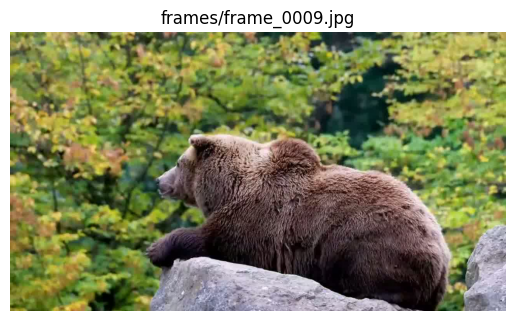

In [65]:
from PIL import Image
import matplotlib.pyplot as plt
import os

assert os.path.exists(filename), f"Image not found: {filename}"

img = Image.open(filename)
plt.figure()
plt.imshow(img)
plt.title(filename)
plt.axis("off")
plt.show()

In [ ]:
## 